## Importing libraries

In [1]:
import pandas as pd
import numpy as np 
from csv import DictReader
import html
import tensorflow as tf
tf.random.set_seed(1337)
# from tensorflow import set_random_seed
# set_random_seed(1337)
np.random.seed(1337)
import random
random.seed(1337)
import os
import string
from collections import defaultdict
import re
# import scipy
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import collections

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
wordnetlem = nltk.WordNetLemmatizer()
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from gensim.summarization import summarize # ? 

from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda
from keras.layers.wrappers import Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adagrad
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.layers import concatenate,dot
from keras.preprocessing import sequence
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


## Reading dataset

In [2]:
# Train set

train_bodies ="/content/drive/My Drive/641/train_bodies.csv"
train_bodies = pd.read_csv(train_bodies)

train_stances="/content/drive/My Drive/641/train_stances.csv"
train_stances = pd.read_csv(train_stances)

# Competition test 

competition_test_bodies="/content/drive/My Drive/641/competition_test_bodies.csv"
competition_test_bodies=pd.read_csv(competition_test_bodies)

competition_test_stances="/content/drive/My Drive/641/competition_test_stances.csv"
competition_test_stances=pd.read_csv(competition_test_stances)

# Competition test unlabeled 

competition_test_stances_unlabeled="/content/drive/My Drive/641/competition_test_stances_unlabeled.csv"
competition_test_stances_unlabeled=pd.read_csv(competition_test_stances_unlabeled)

# Test 

test_bodies="/content/drive/My Drive/641/test_bodies.csv"
test_bodies=pd.read_csv(test_bodies)

test_stances_unlabeled="/content/drive/My Drive/641/test_stances_unlabeled.csv"
test_stances_unlabeled=pd.read_csv(test_stances_unlabeled)

### Checking dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
pip install textblob

In [5]:
# Data explorations  
print("\n\ntrain_bodies\n\n")
print(train_bodies.info())
print("\n\ntrain_stances\n\n")
print(train_stances.info())
print("\n\ncompetition_test_bodies\n\n")
print(competition_test_bodies.info())
print("\n\ncompetition_test_stances\n\n")
print(competition_test_stances.info())
print("\n\ncompetition_test_stances unlabeled\n\n")
print(competition_test_stances_unlabeled.info())
print("\n\ntest_bodies\n\n")
print(test_bodies.info())
print("\n\ntest_stances_unlabeled\n\n")
print(test_stances_unlabeled.info())



train_bodies


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB
None


train_stances


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None


competition_test_bodies


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      904 non-null    int64 
 1   articleBody  904 non-null 

In [6]:

#Adapted from https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py
#Original credit - @bgalbraith
# Function for reading the dataset
class DataSet():
    def __init__(self, name="train", path="/content/drive/My Drive/641"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        if name== 'train':
          stances = name+"_stances_resampled.csv"  
        else:
          stances = name+"_stances.csv"
          
        self.stances = self.read(stances)
       
        articles = self.read(bodies)
       
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])
        
        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))

    

    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

def reshape(input):
    ar_input = np.array(input)  
    ar_input = np.reshape(ar_input,[ar_input.shape[0],ar_input.shape[2]])
    return ar_input

def normalize_word(w):
    return wordnetlem.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    # if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

        return np.load(feature_file)


def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)
def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join((text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features

def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]


    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 
                 + count_grams(headline, body))


    return X



In [7]:
train_stances=pd.read_csv('/content/drive/My Drive/641/train_stances.csv')
train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [8]:
print(train_stances.shape)

(49972, 3)


In [9]:
print("Train Data Distribution: ",collections.Counter(train_stances['Stance']))

Train Data Distribution:  Counter({'unrelated': 36545, 'discuss': 8909, 'agree': 3678, 'disagree': 840})


In [10]:
import matplotlib.pyplot as plt


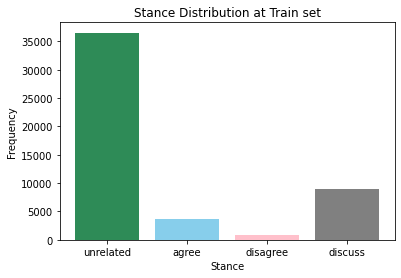

In [11]:
plt.bar(collections.Counter(train_stances['Stance']).keys(),collections.Counter(train_stances['Stance']).values(),color=[
                     'seagreen', 'skyblue','pink','gray'])
plt.xlabel("Stance")
plt.ylabel('Frequency')
plt.title('Stance Distribution at Train set')
plt.show()

In [12]:
train_stances_unrelated=train_stances[train_stances['Stance']=='unrelated']
train_stances_agree=train_stances[train_stances['Stance']=='agree']
train_stances_disagree=train_stances[train_stances['Stance']=='disagree']
train_stances_discuss=train_stances[train_stances['Stance']=='discuss']

In [13]:
print(train_stances_unrelated.shape)
print(train_stances_agree.shape)
print(train_stances_disagree.shape)
print(train_stances_discuss.shape)

(36545, 3)
(3678, 3)
(840, 3)
(8909, 3)


- Total stances: 49972
  - unrelated: 73.1%
  - agree: 7.3%
  - disagree:1.6%
  - discuss:17.8%

### Taking 50% of unrelated only | undersampling the abundant class 
##### https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

In [14]:
train_stances_unrelated=train_stances_unrelated.sample(frac=1).reset_index(drop=True)[0:18272]   #50% undersample

In [15]:
train_stances_unrelated

,Headline,Body ID,Stance
0,This Is What The Sun Baby From ‘Teletubbies’ L...,2081,unrelated
1,The Force Awakens News: Director J.J. Abrams E...,1087,unrelated
2,ISIS executioner 'Jihadi John' named by media,1815,unrelated
3,"Boko Haram agrees to ceasefire, release of sch...",320,unrelated
4,Pentagon: Airstrike killed terror leader in So...,1543,unrelated
...,...,...,...
18267,"Despite no Ebola case in Kansas City, the rumo...",781,unrelated
18268,Tropical spider burrowed under Bali tourist's ...,220,unrelated
18269,Iraqi media says ISIS militants have contracte...,87,unrelated
18270,Lynch mob chop man's penis off after catching ...,1291,unrelated


In [16]:
train_stances_resampled=pd.concat([train_stances_unrelated,train_stances_agree
                                   ,train_stances_disagree,train_stances_discuss],axis=0)

In [17]:
train_stances_resampled=train_stances_resampled.sample(frac=1).reset_index(drop=True)

In [18]:
train_stances_resampled

,Headline,Body ID,Stance
0,Here's video of a bird pooping on Vladimir Put...,2081,disagree
1,"Marine Gets Shot in the Head, Walks Away",860,unrelated
2,Apple Orders More Than 5 Million Watches for I...,855,unrelated
3,Boko Haram ceasefire ignored as violence flare...,1540,agree
4,"Islamic State, in video titled ""A Message to A...",938,unrelated
...,...,...,...
31694,FBI Probing Alleged Audio of Michael Brown Sho...,1073,unrelated
31695,"Michael Phelps' self-proclaimed 'girlfriend', ...",1847,agree
31696,Apple Reportedly Preparing 12-inch MacBook Air...,1679,unrelated
31697,ISIS Video Purports To Show Beheading Of Briti...,1183,discuss


In [19]:
train_stances_resampled.to_csv('/content/drive/My Drive/641/train_stances_resampled.csv',index=False)

In [20]:
#  Random Testing 
# rows=[]
# with open("/content/drive/My Drive/fnc-1/competition_test_bodies.csv", "r", encoding='utf-8') as table:
#     r = DictReader(table)
# # print(r)
#     for line in r:
#         rows.append(line)
# print(rows)

#### Loading the dataset

In [21]:
# Loading the dataset
print("\t\tLoading train set..\n\n ")
train=DataSet()
print("\n\n\t\tLoading test set..\n\n ")
test=DataSet(name="competition_test")

		Loading train set..

 
Reading dataset
Total stances: 31699
Total bodies: 1683


		Loading test set..

 
Reading dataset
Total stances: 25413
Total bodies: 904


### 1. checking dataset
### 2. checking number of common headlines

In [22]:
print("\t\tchecking train.stances\n")
print(type(train.stances))
print(type(train.stances[0]))
print(train.stances[0])

print("\t\tchecking train.articles\n")
print(type(train.articles))
print(type(train.articles[0]))
print(train.articles[0][0:50])

print("\n\n")


		checking train.stances

<class 'list'>
<class 'collections.OrderedDict'>
OrderedDict([('Headline', "Here's video of a bird pooping on Vladimir Putin in the middle of a speech"), ('Body ID', 2081), ('Stance', 'disagree')])
		checking train.articles

<class 'dict'>
<class 'str'>
A small meteorite crashed into a wooded area in Ni





In [23]:
def unique_headlines(data):
    unique_headlines = []
    metric='Body ID'                               #Headline
    for stance in data.stances:
        if stance[metric] not in unique_headlines:
            unique_headlines.append(stance[metric])
    return unique_headlines
unique_headlines_train=unique_headlines(train)
print(len(unique_headlines_train))
print(len(train.stances))
print(len(train.articles))

1683
31699
1683


#### Result:
- For each body in articles there are multiple headlines in stances.
- Same headlines are repeated for different Body id's.


In [24]:
# Preprocessing the data..
def preprocess_data(data_text):

    data_text = html.unescape(data_text)   # To decode the eascaped data
    
    data_text = data_text.replace("\\n"," ")    
    data_text = re.sub(r"n\'t", " not", data_text)

    data_text = re.sub('[^A-Za-z0-9]+', ' ', data_text) 

    data_text = re.sub(r'[^\x00-\x7F]',' ', data_text)  # Removing all Non ASCII characters 
    
    data_text = re.sub(r'[^\w\s]',' ',data_text)
    data_text = re.sub("\d+", " ", data_text)  
    # data_text = re.sub(r"\s+", " ", data_text)          # replacing 1 or more spaces by 1 space

    data_text = data_text.rstrip('.|,|;|\'|\"')       # Removing trailing characters
    data_text = data_text.lstrip('\'|\"')             # Removing leading characters
    data_text = data_text.strip()
    data_text = data_text.lower()

    stopwords_list=[ 'we', 'our', 'ours', 'ourselves', 'you', "you're",'i', 'me', 'he',
                     'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 's']
          
                  # Removing stopwords

    temp=[word for word in data_text.split() if word not in stopwords_list]
    clean_text=" ".join(temp)
    return clean_text 


def generate_clean_data(dataset,full_list,Headline):
    if Headline:
        for stance in dataset.stances:
            clean_text=preprocess_data(stance['Headline'])
            full_list.append(clean_text)
    else:
        for id in dataset.articles:
            clean_text=preprocess_data(dataset.articles[id])
            full_list.append(clean_text)
    return full_list

In [25]:
full_list= []
full_list=generate_clean_data(train,full_list,True)
all_data=generate_clean_data(train,full_list,False)

In [26]:
len(all_data)

33382

In [27]:
all_data[0]

'here video of a bird pooping on vladimir putin in the middle of a speech'

### fit on texts /

In [28]:
# fit on texts.. 
token = Tokenizer()
token.fit_on_texts(all_data) # list of strings 

print("Document size: ",token.document_count)
print("vocab size: ", len(token.word_counts))


Document size:  33382
vocab size:  22561


In [29]:
print("word index checking: ",token.word_index)

word index checking:  {'the': 1, 'to': 2, 'in': 3, 'a': 4, 'of': 5, 'and': 6, 'is': 7, 'that': 8, 'on': 9, 'for': 10, 'was': 11, 'it': 12, 'with': 13, 'isis': 14, 'not': 15, 'by': 16, 'at': 17, 'as': 18, 'have': 19, 'has': 20, 'said': 21, 'from': 22, 'be': 23, 'after': 24, 'who': 25, 'an': 26, 'are': 27, 'apple': 28, 'been': 29, 'this': 30, 'video': 31, 'state': 32, 'but': 33, 'foley': 34, 'had': 35, 'they': 36, 'man': 37, 'islamic': 38, 'says': 39, 'watch': 40, 'new': 41, 'james': 42, 'journalist': 43, 'will': 44, 'american': 45, 'michael': 46, 'u': 47, 'kim': 48, 'us': 49, 'up': 50, 'about': 51, 'no': 52, 'haram': 53, 'report': 54, 'boko': 55, 'reports': 56, 'claims': 57, 'brown': 58, 'ebola': 59, 'one': 60, 'out': 61, 'were': 62, 'all': 63, 'leader': 64, 'there': 65, 'audio': 66, 'jong': 67, 'more': 68, 'or': 69, 'over': 70, 'al': 71, 'killed': 72, 'news': 73, 'militants': 74, 'reportedly': 75, 'missing': 76, 'which': 77, 'when': 78, 'their': 79, 'could': 80, 'shooting': 81, 'would'

### Making embedding matrix

In [30]:
found_count =0
not_found_count = 0

# loading the glove and making an embedding dictionary
emb_index = dict()
with open("/content/drive/My Drive/641/glove.6B.200d.txt",encoding="utf8") as f:
  for line in f:
    emb_index[line.split()[0]] = np.asarray(line.split()[1:], dtype='float32')
  f.close()


embedding_matrix = np.zeros((len(token.word_index) + 1,200))
for word, index in token.word_index.items():
    emb_vector = emb_index.get(word) # getting the vector from the glove dictionary 
    if emb_vector is not None:
        embedding_matrix[index] = emb_vector
        found_count+=1    # to check the count of available vectors in glove dict 
    else:
        not_found_count+=1  
print("Vocab found in glove: ",found_count)
print("Vocab not found in glove: ",not_found_count)

Vocab found in glove:  20786
Vocab not found in glove:  1775


In [31]:
def sequencing(data,token):
    headline=[]
    body=[]
    target=[]
    categories={'unrelated': 0 , 'agree':1, 'disagree':2, 'discuss':3}
    for stance in data.stances:
        headline.append(preprocess_data(stance['Headline']))             # Making a list of all headlines
        body.append(preprocess_data(data.articles[int(stance['Body ID'])]))  # Making a list of all repeated bodies for each headline. 
        target.append(categories[stance['Stance']])
        
    headline = token.texts_to_sequences(headline)
    body = token.texts_to_sequences(body)
    headline = pad_sequences(headline,maxlen=30 ,padding = 'post')    # returns numpy arrays
    body = pad_sequences(body,maxlen=50,padding = 'post')             # RETURNS numpy array with padded sequences 
  
    categorical_target= np.zeros((len(target),4))
    categorical_target= to_categorical(target, num_classes=4)         # numpy array with categorical target values
    return headline,body,categorical_target

In [32]:
X_train_headline,X_train_body,y_train= sequencing(train,token)
X_test_headline,X_test_body,y_test = sequencing(test,token)

In [33]:
print("X_train_headline: ",X_train_headline.shape)
print("X_train_body: ",X_train_body.shape)
print("y_train: ",y_train.shape)

print("X_test_headline: ",X_test_headline.shape)
print("X_test_body: ",X_test_body.shape)
print("y_test: ",y_test.shape)

X_train_headline:  (31699, 30)
X_train_body:  (31699, 50)
y_train:  (31699, 4)
X_test_headline:  (25413, 30)
X_test_body:  (25413, 50)
y_test:  (25413, 4)


In [34]:
#getting headline and the article
def head_body(dataset):
    headline =[]
    article_body=[]
    for stance in dataset.stances:
        headline.append(stance['Headline'])
        article_body.append(dataset.articles[int(stance['Body ID'])])
    return (headline,article_body)

## Generating hand features

In [35]:
# generating hand features 
def Generate_features(feature,dataset,name):
    headline,article_body=head_body(dataset)
    features =gen_or_load_feats(feature,headline,article_body, '/content/drive/My Drive/641/'+str(feature.__name__)+name+'.npy')
    return features


## Hand train features

In [36]:
train_hand_features = np.hstack([Generate_features(hand_features,train,'train'),
                            Generate_features(word_overlap_features,train,'train'),
                            Generate_features(refuting_features,train,'train'),
                            Generate_features(polarity_features,train,'train')])


31699it [01:42, 308.04it/s]
31699it [01:56, 272.17it/s]
31699it [00:06, 5073.79it/s]
31699it [01:55, 274.93it/s]


## Hand test features

In [37]:
test_hand_features = np.hstack([Generate_features(hand_features,test,'test'),
                            Generate_features(word_overlap_features,test,'test'),
                            Generate_features(refuting_features,test,'test'),
                            Generate_features(polarity_features,test,'test')])

25413it [01:18, 323.59it/s]
25413it [01:24, 299.58it/s]
25413it [00:04, 5086.47it/s]
25413it [01:35, 266.15it/s]


## Function for fetching unique headline and article body

In [38]:
def head_body_no_duplicacy(dataset):
    
    headline =[]
    article_body=[]
    for stance in dataset.stances:
        if stance['Headline'] not in headline:
            headline.append(stance['Headline'])
    for i in dataset.articles.keys():
        article_body.append(dataset.articles[i])
       
    return headline,article_body

## Constructing tranformer and tfidf vectorizer

In [39]:
def transformer_tfidfVectorizer(train,test):
    unique_train_headline,unique_train_body = head_body_no_duplicacy(train)
    unique_test_headline,unique_test_body = head_body_no_duplicacy(test)

    count_vectorizer = CountVectorizer(max_features=4500, stop_words='english')
    count = count_vectorizer.fit_transform(unique_train_headline + unique_train_body)
    transformer = TfidfTransformer(use_idf=False).fit(count)
    tfidf_vectorizer = TfidfVectorizer(max_features=4500, stop_words='english').fit(unique_train_headline + unique_train_body+unique_test_headline+unique_test_body)
    return count_vectorizer,transformer,tfidf_vectorizer

## Forming tfidf and cosine similarity features for train set

In [40]:
def tfidf_train(train,test):  
    count_vectorizer,transformer,tfidf_vectorizer=transformer_tfidfVectorizer(train,test)
    tfidf_train_head=[]
    tfidf_train_body = []
    cosine_sim_train = []
    dictinary_heading = dict()
    dictinary_body = dict()
    
    for stance in train.stances:
        heading = stance['Headline']
        body = train.articles[int(stance['Body ID'])]
        if heading not in dictinary_heading:
            dictinary_heading[heading] = (transformer.transform(count_vectorizer.transform([heading])).toarray(),tfidf_vectorizer.transform([heading]).toarray())
        if body not in dictinary_body:
            dictinary_body[body] = (transformer.transform(count_vectorizer.transform([body])).toarray(),tfidf_vectorizer.transform([body]).toarray())
        
        tfidf_train_head.append(dictinary_heading[heading][0])
        tfidf_train_body.append(dictinary_body[body][0])
        cosine_sim_train.append(cosine_similarity(dictinary_heading[heading][1],dictinary_body[body][1]))
    return tfidf_train_head,tfidf_train_body,cosine_sim_train

## Forming tfidf and cosine similarity features for test set

In [41]:
def tfidf_test(train,test):  
    count_vectorizer,transformer,tfidf_vectorizer=transformer_tfidfVectorizer(train,test)
    tfidf_test_head=[]
    tfidf_test_body = []
    cosine_sim_test = []
    dictinary_heading = dict()
    dictinary_body = dict()
    
    for stance in test.stances:
        heading = stance['Headline']
        body = test.articles[int(stance['Body ID'])]
        if heading not in dictinary_heading:
            dictinary_heading[heading] = (transformer.transform(count_vectorizer.transform([heading])).toarray(),tfidf_vectorizer.transform([heading]).toarray())
        if body not in dictinary_body:
            dictinary_body[body] = (transformer.transform(count_vectorizer.transform([body])).toarray(),tfidf_vectorizer.transform([body]).toarray())
        
        tfidf_test_head.append(dictinary_heading[heading][0])
        tfidf_test_body.append(dictinary_body[body][0])
        cosine_sim_test.append(cosine_similarity(dictinary_heading[heading][1],dictinary_body[body][1]))
    return tfidf_test_head,tfidf_test_body,cosine_sim_test

In [42]:
def tfidf_features(train,test):
 
    tfidf_train_head,tfidf_train_body,cosine_sim_train=tfidf_train(train,test)

    tfidf_test_head,tfidf_test_body,cosine_sim_test=tfidf_test(train,test) 
    
    
    return (tfidf_train_head,tfidf_train_body,cosine_sim_train,tfidf_test_head,tfidf_test_body,cosine_sim_test)

## Forming tfidf and cosine similarity features to be passed on to the neural network

In [43]:
tfidf_train_head,tfidf_train_body,cosine_sim_train,tfidf_test_head,tfidf_test_body,cosine_sim_test=tfidf_features(train,test)

tfidf_train_head = reshape(tfidf_train_head)
tfidf_train_body = reshape(tfidf_train_body)
cosine_sim_train = reshape(cosine_sim_train)

tfidf_test_head = reshape(tfidf_test_head)
tfidf_test_body = reshape(tfidf_test_body)
cosine_sim_test = reshape(cosine_sim_test)
tfidf_train = np.hstack([tfidf_train_head,cosine_sim_train, tfidf_train_body])
tfidf_test = np.hstack([tfidf_test_head,cosine_sim_test,tfidf_test_body])

In [44]:
tfidf_train.shape

(31699, 9001)

In [45]:
tfidf_train_head.shape

(31699, 4500)

## Polarity features train

In [46]:
from textblob import TextBlob

In [47]:
#Polarity features train
new_features =[]
dict_pol = dict()
for stance in train.stances:        
    if stance['Headline'] not in dict_pol:
        dict_pol[stance['Headline']] = TextBlob(preprocess_data(stance['Headline'])).sentiment.polarity
    if train.articles[int(stance['Body ID'])] not in dict_pol:
        dict_pol[train.articles[int(stance['Body ID'])]] = TextBlob(preprocess_data(train.articles[int(stance['Body ID'])])).sentiment.polarity
        
    head = dict_pol[stance['Headline']]
    body = dict_pol[train.articles[int(stance['Body ID'])]]
    new_features.append([head,body,body-head])
pol_train=np.array(new_features)    

## Polarity features test

In [48]:
#Polarity features test
new_features_test =[]
dict_pol_test = dict()
for stance in test.stances:        
    if stance['Headline'] not in dict_pol_test:
        dict_pol_test[stance['Headline']] = TextBlob(preprocess_data(stance['Headline'])).sentiment.polarity
    if test.articles[int(stance['Body ID'])] not in dict_pol_test:
        dict_pol_test[test.articles[int(stance['Body ID'])]] = TextBlob(preprocess_data(test.articles[int(stance['Body ID'])])).sentiment.polarity
        
    head_test = dict_pol_test[stance['Headline']]
    body_test = dict_pol_test[test.articles[int(stance['Body ID'])]]
    new_features_test.append([head_test,body_test,body_test-head_test])
pol_test=np.array(new_features_test)   

## Evaluating test data

In [49]:
# Evaluating answer
def answer(model,model_input, target):
    stances_real = {0:'unrelated', 1: 'agree', 2: 'disagree', 3: 'discuss'}
    predicted = model.predict(model_input)
    predicted = np.argmax(predicted,axis = 1)
    t = np.argmax(target,axis = 1)
    actual =[]
    pred = []
    for i in predicted:
        pred.append(stances_real[i])
    for i in t:
        actual.append(stances_real[i])
    report_score(actual, pred)
    print(predicted)
    
    
    predicted_new=[]
    for i in range(len(predicted)):
        if predicted[i] == 0: predicted_new.append("unrelated")
        elif predicted[i] == 1: predicted_new.append("agree")
        elif predicted[i] == 2: predicted_new.append("disagree")
        elif predicted[i] == 3: predicted_new.append("discuss")
    print(predicted_new)       
    id_body = []
    head = []
    stances = np.copy(np.array(predicted_new))

    for i in range(len(test.stances)):
        id_body.append(test.stances[i]['Body ID'])
        head.append(test.stances[i]['Headline'])
    submission_data = pd.DataFrame(columns=['Headline', 'Body ID', 'Stance'])
    submission_data['Headline'] = head
    submission_data['Body ID'] = id_body
    submission_data['Stance'] = stances
    print(submission_data.head())

    submission_data.to_csv('/content/drive/My Drive/641/bi_lstm_2_nets.csv', index=False, encoding='utf-8')
    return stances

## Model

In [50]:
headline = Input(shape=(30,), dtype='int32')
article_body = Input(shape=(50,), dtype='int32')
# Starting with the embedding layer
base_embedding = Embedding(len(token.word_index) + 1,200,weights=[embedding_matrix],trainable=False)
# Now calculating headline embedding and article body embedding
headline_embedding = base_embedding(headline)
article_body_embedding = base_embedding(article_body)
# Defining the Bidirectional LSTM to be used
combined_lstm = Bidirectional(LSTM(128,dropout=0.3))
# Adding the headline embeddings to the bidirectional LSTM
headline_lstm = combined_lstm(headline_embedding)
# Adding the article body embeddings to the bidirectional LSTM
article_body_lstm = combined_lstm(article_body_embedding)
# Combining the  headline_lstm and article_body_lstm layers
combining_layer = dot([headline_lstm,article_body_lstm],axes = 1, normalize=True)
# Now we are defining the input shape of the hand features layer
hand_feature_in = Input(shape=(train_hand_features.shape[1],))
# Now we are defining the input shape of the tfidf features layer
tfidf_features_input = Input(shape = (tfidf_train.shape[1],))
# Now we are using the dense layer that is fully connected layer with number of neurons =128 and activation function ReLU
dense_tfidf_features = Dense(128,activation='relu')(tfidf_features_input)
# Now we are adding the Dropout to help the model avoid overfitting and generalize well
dense_tfidf_features = Dropout(0.5)(dense_tfidf_features)
# Now we are defining the input shape of the textblob polarity features layer
polarity_input = Input(shape=(pol_train.shape[1],))
# Now we cobining all the features layer
final_combined = concatenate([headline_lstm,article_body_lstm,combining_layer,hand_feature_in,dense_tfidf_features,polarity_input])
# We are adding dense layer with 128 neurons and activation function ReLU
dense_layer = Dense(128,activation='relu')(final_combined)
# We are adding final drop out to avoid overfitting
dense_layer = Dropout(0.2)(dense_layer)
# At the end is fully connected(Dense) layer with 4 neurons firing for 4 target stances we have. Here we have used softmax activation 
# which is also called crossentropy error and is used in combination with categorical_crossentropy for efficient results
dense_layer = Dense(4,activation='softmax')(dense_layer)
# The model we have just created
bi_model = Model(inputs=[headline,article_body,hand_feature_in,tfidf_features_input,polarity_input], outputs=[dense_layer])
# Compiling the model
bi_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# Showing the architecture of the model we have created
print(bi_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             4512400     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 9001)         0                                      

## Traning the model

In [51]:
model_h=bi_model.fit([X_train_headline,X_train_body,train_hand_features,tfidf_train,pol_train],[y_train],epochs=15, batch_size=64,verbose = True)


Epoch 1/15
31699/31699 [==============================] - 215s 7ms/step - loss: 0.3869 - accuracy: 0.8591
Epoch 2/15
31699/31699 [==============================] - 213s 7ms/step - loss: 0.1722 - accuracy: 0.9368
Epoch 3/15
31699/31699 [==============================] - 218s 7ms/step - loss: 0.1170 - accuracy: 0.9559
Epoch 4/15
31699/31699 [==============================] - 214s 7ms/step - loss: 0.0883 - accuracy: 0.9670
Epoch 5/15
31699/31699 [==============================] - 213s 7ms/step - loss: 0.0684 - accuracy: 0.9738
Epoch 6/15
31699/31699 [==============================] - 214s 7ms/step - loss: 0.0562 - accuracy: 0.9805
Epoch 7/15
31699/31699 [==============================] - 214s 7ms/step - loss: 0.0475 - accuracy: 0.9833
Epoch 8/15
31699/31699 [==============================] - 214s 7ms/step - loss: 0.0430 - accuracy: 0.9842
Epoch 9/15
31699/31699 [==============================] - 213s 7ms/step - loss: 0.0367 - accuracy: 0.9866
Epoch 10/15
31699/31699 [=====================

## Plots

In [52]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(7,6))
# plt.plot(model_h.history['accuracy'])
# plt.plot(model_h.history['val_accuracy'])
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.title('Accuracy per epoch')
# plt.legend(['Train accuracy', 'Val accuracy'])
# plt.savefig("Bi_lstm_2_acc.png")
# plt.show()

# plt.figure(figsize=(8,7))
# plt.plot(model_h.history['loss'])
# plt.plot(model_h.history['val_loss'])
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.title('Loss per epoch')
# plt.legend(['Train Loss', 'Val Loss'])
# plt.savefig("Bi_lstm_2_loss.png")
# plt.show()

In [53]:
bi_model.evaluate([X_test_headline,X_test_body,test_hand_features,tfidf_test,pol_test],y_test)

25413/25413 [==============================] - 60s 2ms/step


[0.8688727780470443, 0.8767560124397278]

In [54]:
predicted_new=answer(bi_model,[X_test_headline,X_test_body,test_hand_features,tfidf_test,pol_test],y_test)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    762    |    48     |    958    |    135    |
-------------------------------------------------------------
| disagree  |    143    |    72     |    356    |    126    |
-------------------------------------------------------------
|  discuss  |    334    |    72     |   3797    |    261    |
-------------------------------------------------------------
| unrelated |    70     |    31     |    598    |   17650   |
-------------------------------------------------------------
Score: 9521.25 out of 11651.25	(81.7186997103315%)
[0 0 0 ... 0 0 3]
['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrela

In [55]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [56]:
def calculate_f1_scores(y_true, y_predicted):
    
    f1_macro = f1_score(y_true, y_predicted, average='macro')
    f1_classwise = f1_score(y_true, y_predicted, average=None, labels=["agree", "disagree", "discuss", "unrelated"])

    resultstring = "F1 macro: {:.3f}".format(f1_macro * 100) + "% \n"
    resultstring += "F1 agree: {:.3f}".format(f1_classwise[0] * 100) + "% \n"
    resultstring += "F1 disagree: {:.3f}".format(f1_classwise[1] * 100) + "% \n"
    resultstring += "F1 discuss: {:.3f}".format(f1_classwise[2] * 100) + "% \n"
    resultstring += "F1 unrelated: {:.3f}".format(f1_classwise[3] * 100) + "% \n"
    return resultstring


In [57]:
def class_repo(labels_test,preds_test):
    eval_report = classification_report(labels_test, preds_test)
    print('Test report', eval_report)

In [58]:
competition_test_stances.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [59]:
print(calculate_f1_scores(competition_test_stances['Stance'],predicted_new))

F1 macro: 58.601% 
F1 agree: 47.447% 
F1 disagree: 15.652% 
F1 discuss: 74.649% 
F1 unrelated: 96.657% 



In [60]:
print(class_repo(competition_test_stances['Stance'],predicted_new))

Test report               precision    recall  f1-score   support

       agree       0.58      0.40      0.47      1903
    disagree       0.32      0.10      0.16       697
     discuss       0.67      0.85      0.75      4464
   unrelated       0.97      0.96      0.97     18349

    accuracy                           0.88     25413
   macro avg       0.64      0.58      0.59     25413
weighted avg       0.87      0.88      0.87     25413

None


In [61]:
print(" Accuracy is: ",accuracy_score(competition_test_stances['Stance'],predicted_new))

 Accuracy is:  0.8767559910282139
